# Hyper-personalization Through Product Reviews: Exploring New Market Opportunites

A multi-modal approach to generating user recommendations.

## Import Libraries and Define File Paths

In [1]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset as LightFMDataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import train_test_split as train_test_split_surprise
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode
import uuid

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Define Utility Functions and Dataset Generation Functions

In [2]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data, folder_names):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data, folder_name in zip(json_data, folder_names):
        if ('body' not in product_data or 'reviews' not in product_data['body'] or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_info = product_data['body'].get('productInformation', {})
        product_name = product_data['body'].get('name', 'Unknown Product')
        asin = product_data['body'].get('canonicalUrl', '').split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0 or asin == '':
            continue

        if not isinstance(product_info, dict):
            product_info = {}

        product = {'ASIN': asin, 'name': clean_str(product_name)}
        breadcrumbs = product_data['body'].get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            #for ig in ignore:
            #    if ig in name:
            #        flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        for key, value in product_info.items():
            cleaned_key = clean_str(key)
            if cleaned_key not in ['dimensions', 'country_of_origin', 'batteries_included', 'weight', 'height', 'size',
                                   'model', 'manufacturer', 'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                                   'capacity', 'number_of_items', 'import', 'lxwxh', 'product_included']:
                product[cleaned_key] = value
        products.append(product)
        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name,
                'folder_name': folder_name
            })
            asins.append(asin)

        for r in reviews_data:
            review = {
                'folder_name': folder_name,
                'ASIN': asin,
                'ProductName': clean_str(product_name),
                'price': product_data['body'].get('rawPrice', 0),
                'image': product_data['body'].get('mainImage', None)
            }
            reviewer_link = r.get('reviewerLink', '').split('/')[-1].split('.')[-1]
            review['reviewerID'] = r.get('reviewerName', 'Unknown') + '_' + (reviewer_link if len(reviewer_link) > 0 else str(uuid.uuid4()))
            reviewRating = re.findall(r'(\d+\.\d+)', r.get('reviewRating', ''))
            reviewDate = re.findall(r'on (.+)$', r.get('reviewDate', ''))
            reviewVotes = re.findall(r'(\d+)', r.get('reviewVotes', '0'))
            reviewLocation = r.get('reviewDate', '').split('on')[0].split(' in ')[-1].replace('the ', '')

            review['customerReview'] = float(reviewRating[0]) if reviewRating else np.nan
            review['reviewDate'] = reviewDate[0] if reviewDate else 'Unknown'
            review['reviewLocation'] = reviewLocation if reviewLocation else 'Unknown'
            review['reviewVotes'] = int(reviewVotes[0]) if reviewVotes else 0
            reviews.append(review)

    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    folder_names = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                            folder_names.append(dir)
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data, folder_names

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [3]:
all_json_data, folder_names = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data, folder_names)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 5622.47it/s]


Error loading JSON from file ../dataset/extracts/amazon/stove/items/amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 5463.66it/s]


### Preprocess itemset

In [4]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.drop(['level_0', 'name'], axis=1, inplace=True)
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [5]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 5]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby(
    'reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

In [6]:
categories_dict = {
    "Children": ["action figures", "building toys", "toddler toy", "toy airplanes", "toy cars",
                 "toy dolls", "baby bottle", "baby formula", "baby wipes", "car seat", "crib",
                 "diaper", "nursery", "pacifier", "stroller"],
    "Books": ["adventure novel", "fantasy novel", "mystery novel", "nonfiction novel",
              "romance novels", "science fiction novel", "thriller novel", "young adult novel"],
    "Cleaning Material": ["vacuum", "detergent", "mop", "broom", "dishwasher", "fabric conditioner"],
    "Kitchen": ["utensils", "air fryer", "coffee maker", "frying pan", "kitchen knife",
                "microwave", "oven", "over the counter", "steamer", "stove", "kitchen", "dining room"],
    "Bedroom": ["bedding", "bedroom", "toilet", "playroom", "desk lamp", "iron",
                "lamp", "bedframe", "bookshelf", "cabinet", "desk", "dresser", "nightstand"],
    "Living Room": ["carpet", "home decor", "living room", "ring doorbell",
                    "wall mount", "curtain", "coffee table", "couch", "chair", "furniture", "patio", "shoe rack"],
    "Bathroom": ["bathroom", "mattress", "pillow", "air purifier",
                 "washing machine", "air freshener", "mirror", "linen"],
    "Fashion": ["belt", "cap", "coat", "dress", "face mask", "jewelry", "men bag", "men jeans",
                "men shirt", "men shoes", "men sweater", "socks", "underwear", "women bag",
                "women jeans", "women shirt", "women shirt", "women shoes", "women sweater", "workout clothes"],
    "Electronic Devices": ["camera", "headphones", "laptop", "monitor", "smart watch", "speakers",
                           "surveillance camera", "tablet", "television", "videogame console", "wifi router"],
    "Peripheral Devices": ["keyboard", "mouse", "webcam", "microphone",
                           "printer", "projector", "usb", "computer accessories"],
    "Computer Components": ["pc ram", "cpu cooler", "gpu", "hard drive",
                            "intel amd processor", "motherboard", "pc chassis", "pc fan", "pc power supply", "solid state drive"],
    "Mobile Accessories": ["cables", "chargers", "phone case", "screen protector", "tripod"],
    "Personal Care": ["conditioner", "deodorant", "face wash", "facial toner",
                      "feminine wash", "lotion", "makeup", "moisturizer", "mouthwash",
                      "shaving cream", "shampoo", "soap", "tampon", "tissue", "toothbrush", "vitamins"],
    "Car Stuff": ["car accessories", "dash cam", "gps", "ram vehicles", "tires", "garage"],
    "Office Supplies": ["office chair", "folder", "home_office", "notebook",
                        "school supplies", "stationery", "seat cushion"],
    "Travel Essentials": ["first aid", "luggage", "packing cubes", "stanley cup",
                          "travel essentials", "water flask", "portable fan"]
}

In [7]:
inverted_categories_dict = {}
for category, items in categories_dict.items():
    for item in items:
        inverted_categories_dict[item] = category


def map_folder_to_category(folder_name):
    return inverted_categories_dict.get(folder_name, "Unknown")


all_reviews_df['category'] = all_reviews_df['folder_name'].apply(map_folder_to_category)
all_reviews_df.to_csv(f"{dir}/reviews.csv")

## Load Dataset

In [8]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (451, 33510)
shape of items_df: (33510, 2438)
shape of asins_df: (33510, 2)


# Exploratory Data Analysis

In [49]:
# Specify the directory containing all CSV files
directory = "../dataset/clean_data/"

# Initialize an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# List of categories
categories = ["Children", "Books", "Cleaning Material", "Kitchen", 
              "Bedroom", "Living Room", "Bathroom", "Fashion", "Electronic devices", 
              "Peripheral Devices", "Computer Components", "Mobile Accessories", 
              "Personal Care", "Car Stuff", "Office Supplies", "Travel Essentials"]

# Iterate over each category
for category in categories:
    # Construct the file path for the current category
    file_path = os.path.join(directory, f"{category}/items_{category}.csv")
    
    # Check if the file exists
    if os.path.exists(file_path):
        # Read the CSV file into a DataFrame
        category_df = pd.read_csv(file_path, low_memory=False)
        
        # Add a 'Category' column with the current category name
        category_df['Category'] = category
        
        # Merge the current category DataFrame with the merged DataFrame
        merged_df = pd.concat([merged_df, category_df], ignore_index=True)
    else:
        print(f"File not found for category: {category}")

In [50]:
# Define a function to get the top 10 reviews per category
def top_reviews_per_category(df):
    return df.nlargest(10, 'customerReview')

# Group the DataFrame by 'Category' and apply the function
top_10_reviews_per_category = merged_df.groupby('Category', group_keys=False).apply(top_reviews_per_category)

# Select only the desired columns and rename them
top_10_reviews_per_category = top_10_reviews_per_category[['name', 'customerReview', 'Category']].rename(columns={'name':'Product Name','customerReview': 'Customer Review'})

# Display the top 10 reviews per category
display(top_10_reviews_per_category)


,Product Name,Customer Review,Category
13571,"twin xl mattress, 8 inch twin bed mattress, twin memory foam mattress with certipur-us certified, twin size mattresses with cool sleep & comfort support, twin xl memory foam mattress, fiberglass free",5.0,Bathroom
13579,"olixis tri-fold memory foam mattress - 4 inch twin size portable floor bed, foldable mat for kids and adults, collapsible and washable cover with certipur-us certified, for travel & camping & yoga",5.0,Bathroom
13589,"avenco king mattress, 12 inch gel memory foam mattress king size, mattress in a box for cool sleep and pressure relief, medium firm mattress with motion isolation, certipur-us certified",5.0,Bathroom
13610,"novilla twin mattress, 10 inch twin hybrid mattress for kids, pocket innerspring pillow top mattress twin for motion isolation, pressure relief & edge support, medium soft feel",5.0,Bathroom
13632,"avenco queen mattress, 12 inch gel memory foam mattress queen size, mattress in a box for cool sleep and pressure relief, medium firm mattress with motion isolation, certipur-us certified",5.0,Bathroom
...,...,...,...
33049,"first aid only eye wash, 1 fluid ounce",5.0,Travel Essentials
33065,"first aid only 746005 ansi 2015 compliant large metal smartcompliance food service first aid cabinet, with medications",5.0,Travel Essentials
33075,4 shelf empty industrial first aid box with first aid logo,5.0,Travel Essentials
33091,johnson & johnson first aid to go- mini first aid kit,5.0,Travel Essentials


In [51]:
# Get the top 20 rows with the highest values in the 'customerReviewCount' column
top_20_reviews_count = merged_df.nlargest(20, 'customerReviewCount')

# Select only the desired columns and rename them
top_20_reviews_count = top_20_reviews_count[['ASIN', 'name', 'customerReview', 'customerReviewCount', 'Category']].rename(columns={'name': 'Product name', 'customerReview': 'Customer Review', 'customerReviewCount': 'Customer Review Count'})

# Display the top 20 rows
display(top_20_reviews_count)


,ASIN,Product name,Customer Review,Customer Review Count,Category
3968,0735219109,where the crawdads sing: reese's book club (a novel),4.7,623473.0,Books
19834,B07PXGQC1Q,"apple airpods (2nd generation) wireless ear buds, bluetooth headphones with lightning charging case included, over 24 hours of battery life, effortless setup for iphone",4.7,606528.0,Electronic devices
26638,B07H2V5YLH,"ailun glass screen protector compatible for iphone 11 / iphone xr [6.1 inch], 3 pack tempered glass",4.6,514702.0,Mobile Accessories
13718,B07B4Z9L7M,"amazon basics lightweight super soft easy care microfiber pillow case, standard, bright white, pack of 2, 30"" l x 20"" w",4.5,485684.0,Bathroom
19827,B07J2Z5DBM,tozo t10 bluetooth 5.3 wireless earbuds with wireless charging case ipx8 waterproof stereo headphones in ear built in mic headset premium sound with deep bass for sport black,4.3,360827.0,Electronic devices
28327,B00T0C9XRK,essence | lash princess false lash effect mascara | gluten & cruelty free,4.3,356841.0,Personal Care
3965,1538724731,verity,4.6,330599.0,Books
4606,1538724731,verity,4.6,330598.0,Books
4748,B01GGU0XWC,it ends with us,4.7,310976.0,Books
14930,B06X9GC2H3,"queen size 4 piece sheet set - comfy breathable & cooling sheets - hotel luxury bed sheets for women & men - deep pockets, easy-fit, soft & wrinkle free sheets - light grey oeko-tex bed sheet set",4.5,306999.0,Bathroom


In [52]:
# Remove rows with NaN values in the 'customerReview' column
merged_df = merged_df.dropna(subset=['customerReview'])

# Get the top 20 rows with the highest values in the 'price' column
top_20_expensive_items = merged_df.nlargest(20, 'price')

# Select only the desired columns and rename them
top_20_expensive_items = top_20_expensive_items[['name', 'price', 'customerReview', 'Category']].rename(columns={'name': 'Product name', 'price': 'Top 20 Most Expensive Item'})

# Display the top 20 rows
display(top_20_expensive_items)


,Product name,Top 20 Most Expensive Item,customerReview,Category
24169,"nvidia h100 80 gb graphic card pcie hbm2e memory 350w 900-21010-0000-000 gpu card only, bulk pkg w 1-year warraty",30099.99,1.0,Computer Components
21119,"lg signature 88-inch class oled z2 series alexa built-in 8k smart tv, 120hz refresh rate, ai-powered , dolby vision iq and dolby atmos, wisa ready, cloud gaming (oled88z2pua, 2022)",26044.61,3.7,Electronic devices
22897,"jvc dla-nz9 d-ila laser home theater projector, 3000 lumen, native 4k with 8k e-shiftx technology, frame adapt hdr, 2-hdmi inputs, supports 8k-60p/4k-120p, ideal for gaming, hdr10+",22390.25,5.0,Peripheral Devices
23058,sony vplvw885es 4k hdr laser home theater video projector,21235.86,3.6,Peripheral Devices
9237,"kohler 30754-pa-hb1 k-30754-pa-hb1 numi 2.0 comfort height smart toilet, honed black",9937.50,5.0,Bedroom
21254,samsung un78js9100 curved 78-inch 4k ultra hd smart led tv (2015 model),8998.94,3.1,Electronic devices
9104,"kohler 30754-pa-0 numi 2.0 comfort height smart toilet, white",8625.00,3.3,Bedroom
21291,"sony xr85z9k 85"" 8k bravia xr hdr mini led smart tv with an additional 4 year coverage by epic protect (2022)",7298.00,1.0,Electronic devices
9029,"toto ms989cumfg#01 neorest ah dual flush 1.0 or 0.8 gpf toilet with intergeated bidet seat and ewater white-ms989cumfg, cotton white",5134.43,4.1,Bedroom
6797,jura giga 6 automatic coffee machine with p.e.p. (silver),4998.00,3.0,Kitchen


In [53]:
review_counts = merged_df.groupby('Category')['customerReview'].count().sort_values(ascending=False)

# Display the counts
display(review_counts)

Category
Fashion                4314
Personal Care          3691
Children               3068
Bedroom                2479
Kitchen                2402
Living Room            2147
Electronic devices     2100
Computer Components    1847
Peripheral Devices     1768
Bathroom               1525
Travel Essentials      1484
Cleaning Material      1389
Books                  1281
Office Supplies        1262
Mobile Accessories     1102
Car Stuff               911
Name: customerReview, dtype: int64

In [55]:
# Filter the DataFrame to include only rows where reviewVotes are not null and not equal to 0
filtered_reviews_df = reviews_df.dropna(subset=['reviewVotes'])
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['reviewVotes'] != 0]

# Count the occurrences of review locations
review_location_counts = filtered_reviews_df['reviewLocation'].value_counts()

# Display the counts
display(review_location_counts)


reviewLocation
United States      70906
Canada              3629
Mexico              1251
United Kingdom       878
India                359
Germany              303
Brazil               259
Japan                203
France               165
Spain                144
Italy                144
Australia            111
Singapore             22
Netherlands            4
Name: count, dtype: int64

In [56]:
# Count the review votes per product name
review_votes_counts = reviews_df.groupby('ProductName')['reviewVotes'].sum()

# Sort the review votes counts in descending order
review_votes_counts_sorted = review_votes_counts.sort_values(ascending=False)
reviews_df = reviews_df.applymap(lambda x: x.replace('_', ' ') if isinstance(x, str) else x)


# Select the top 10 products
top_10_products = review_votes_counts_sorted.head(10)

# Display the top 10 products
print(top_10_products)


ProductName
shaperx_bodysuit_for_women_tummy_control_shapewear_seamless_sculpting_thong_body_shaper_tank_top                                                                             2108
pursteam_10in1_steam_mop_floor_steamer_with_detachable_handheld_steam_cleaner_for_tile_hardwood_floors                                                                       1950
eureka_home_lightweight_mini_cleaner_for_carpet_and_hard_floor_corded_stick_vacuum_with_powerful_suction_for_multisurfaces_3in1_handheld_vac_blaze_black                     1874
it_ends_with_us                                                                                                                                                              1872
i_am_watching_you                                                                                                                                                            1570
nizoral_antidandruff_shampoo_with_1%_ketoconazole_fresh_scent_7_fl_oz                             

# Define Trainset and Testset

Get top 20 reviewers

In [9]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[
    non_nan_count.sort_values(ascending=False).index].iloc[:20]
top_uids = df_top_reviewers.index.tolist()
df_non_top_reviewers = df_utility.loc[
    non_nan_count.sort_values(ascending=False).index].iloc[20:]

# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Global Baseline Average

The formula for the global baseline $b_{ui}$ for user $u$ and item $i$ is:

$$ b_{ui} = \mu + b_u + b_i $$

where:
- $\mu$ global average rating across all ratings.
- $b_u$ user bias, calculated as the average rating given by the user minus the global average rating.
- $b_i$ item bias, calculated as the average rating received by the item minus the global average rating.

In [10]:
global_avg = all_reviews_df['customerReview'].mean()
user_avg = all_reviews_df.groupby('reviewerID')['customerReview'].mean()
items_avg = all_reviews_df.groupby('ASIN')['customerReview'].mean()
user_bias = user_avg - global_avg
item_bias = items_avg - global_avg

try:
    all_reviews_df.reset_index(inplace=True)
except:
    pass

predictions = []
for user in top_uids:
    user_specific_df = all_reviews_df[all_reviews_df['reviewerID'] == user]
    rated_items = user_specific_df['ASIN'].unique()
    for item in item_bias.index:
        if item not in rated_items:
            if user in user_bias.index and item in item_bias.index:
                b_ui = global_avg + user_bias[user] + item_bias[item]
                b_ui = min(b_ui, 5)
                predictions.append((user, item, b_ui))
                
predictions_df = pd.DataFrame(predictions, columns=['reviewerID', 'ASIN', 'predicted_rating'])
 
recommendations_global_average_baseline = {}
 
for user in top_uids:
    top_predictions = {}
    user_predictions = predictions_df[predictions_df['reviewerID'] == user]
    preds = user_predictions.sort_values(
        by='predicted_rating', ascending=False).head(10)
    recommendations_global_average_baseline[user] = preds["ASIN"].values

## Neighborhood-based Collaborative Filtering

From Surprise

In [11]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

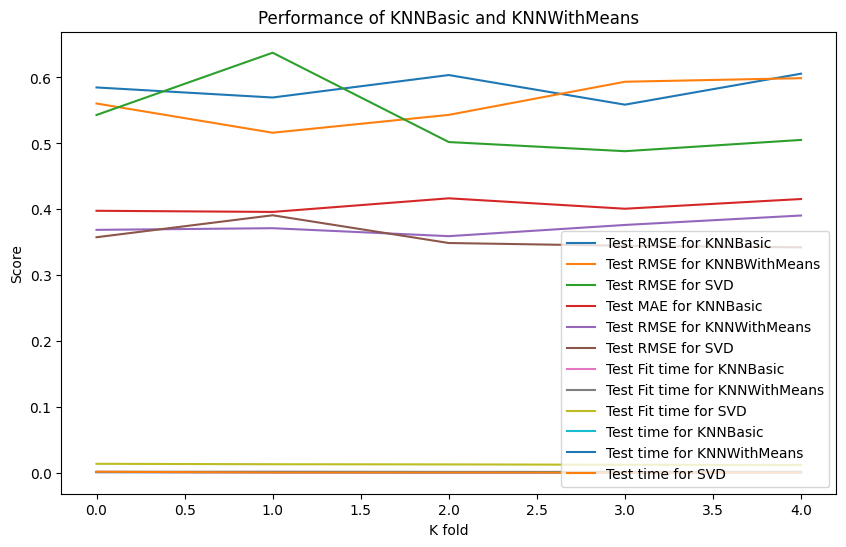

In [12]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

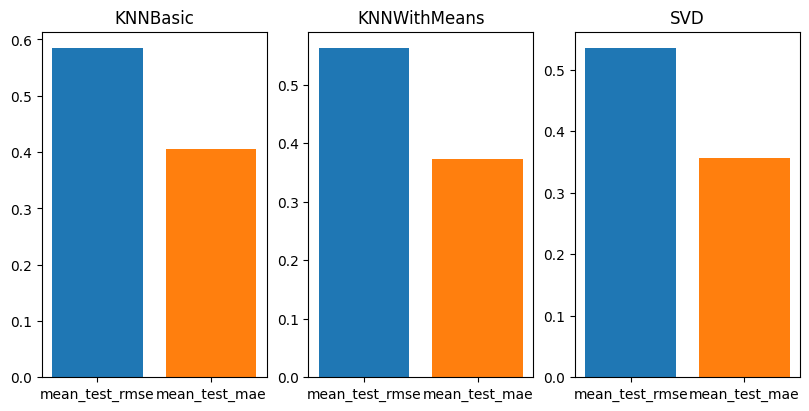

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### NDCG

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py and https://github.com/NicolasHug/Surprise/issues/339

In [14]:
def get_ndcg(surprise_predictions, k_highest_scores=None):
    """ 
    Calculates the ndcg (normalized discounted cumulative gain) from surprise predictions, using sklearn.metrics.ndcg_score and scipy.sparse
  
    Parameters: 
    surprise_predictions (List of surprise.prediction_algorithms.predictions.Prediction): list of predictions
    k_highest_scores (positive integer): Only consider the highest k scores in the ranking. If None, use all. 
  
    Returns: 
    float in [0., 1.]: The averaged NDCG scores over all recommendations
  
    """
    from sklearn.metrics import ndcg_score
    from scipy import sparse
    
    uids = []
    iids = []
    uid_mapping = {}
    iid_mapping = {}

    iter = 0
    for s in surprise_predictions:
        if s.uid in uid_mapping:
            uids.append(uid_mapping[s.uid])
        else:
            uid_mapping[s.uid] = iter
            uids.append(iter)

        if s.iid in iid_mapping:
            iids.append(iid_mapping[s.iid])
        else:
            iid_mapping[s.iid] = iter
            iids.append(iter)

        iter += 1

    r_uis = [p.r_ui for p in surprise_predictions ]
    ests = [p.est for p in surprise_predictions ]
    
    assert(len(uids) == len(iids) == len(r_uis) == len(ests) )    
    
    sparse_preds = sparse.coo_matrix( (ests, (uids , iids )) )
    sparse_vals = sparse.coo_matrix( (r_uis, (uids , iids )) )
    
    dense_preds = sparse_preds.toarray()
    dense_vals = sparse_vals.toarray()
    
    return ndcg_score(y_true= dense_vals , y_score= dense_preds, k=k_highest_scores)

algo_res = {'KNNBasic': {'ndcg': []}, 'KNNWithMeans': {'ndcg': []}, 'SVD': {'ndcg': []}}
method = ["KNNBasic", "KNNWithMeans", "SVD"]
iter = 0
reader = Reader(rating_scale=(0,5))
df_melt_all = (df_utility.reset_index()
                    .melt('reviewerID', var_name='ASIN', value_name='raw_ratings')
                    .dropna())
#trainset = dataset.load_from_df(
#    df_melt_train, reader).build_full_trainset()
trainset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset()
for algo in algos:
    algo.fit(trainset)
    predictions = algo.test(trainset.build_testset())
    ndcg = get_ndcg(predictions, k_highest_scores=10)
    algo_res[method[iter]]['ndcg'].append(ndcg)
    iter += 1

df_metrics_surprise = pd.DataFrame.from_dict({(i,j): algo_res[i][j] 
                           for i in algo_res.keys() 
                           for j in algo_res[i].keys()},
                       orient='index')
df_metrics_surprise.rename(columns={0: 'NDCG'}, inplace=True)
display(df_metrics_surprise)

,NDCG
"(KNNBasic, ndcg)",0.162636
"(KNNWithMeans, ndcg)",0.162639
"(SVD, ndcg)",0.162609


### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [15]:
def get_random_users(lst, n):
    rand_ids = random.sample(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs

user_histories = {}
for uid in top_uids:
    user_histories[uid] = reviews_df.loc[uid]['ASIN'].tolist()

userids_ilocs = get_ilocs(df_utility, top_uids)

In [17]:
def get_top_n(predictions, user_history, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if iid not in user_history:
            top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

testset = dataset.load_from_df(
    df_melt_all, reader).build_full_trainset().build_anti_testset()

algo_names = ['KNNBasic', 'KNNWithMeans', 'SVD']
recommendations_surprise = {'KNNBasic': {}, 'KNNWithMeans': {}, 'SVD': {}}
iter = 0
for algo in algos:
    predictions = algo.test(testset)
    for uid in top_uids:
        top_n = get_top_n(predictions, user_histories[uid], n=10)
        for uid, user_ratings in top_n.items():
            if uid in top_uids:

                recommendations_surprise[
                    algo_names[iter]][uid] = [iid for (iid, _) in user_ratings]
    iter += 1

## Latent-factor based Collaborative Filtering

### ALS

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

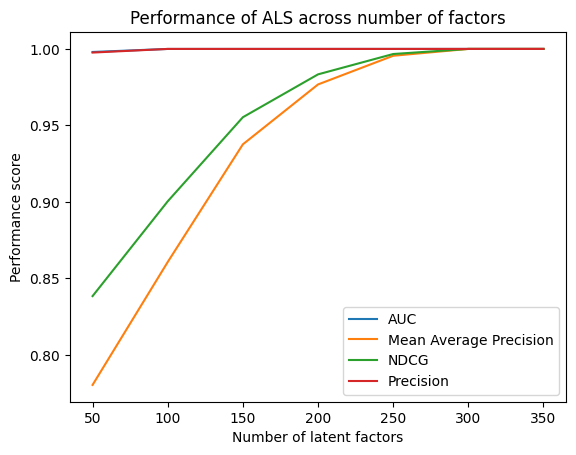

In [18]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
#!export OPENBLAS_NUM_THREADS=1
#threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)
plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [19]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

auc = AUC_at_k(model,training_set,test_set,
            K=len(df_utility), show_progress=True)
ndcg_als = ndcg_at_k(model, training_set, test_set,
            K=len(df_utility), show_progress=True)
precision = precision_at_k(model, training_set,
            test_set, K=len(df_utility), show_progress=True)

print(f"AUC: {auc}")
print(f"precision: {precision}")
print(f"ndcg: {ndcg_als}")

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations_als_ilocs = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]
recommendations_als = {}

for user_ind, reco_ids, scores in recommendations_als_ilocs:
    recos = {}
    reviewer_id = df_utility.iloc[user_ind, :].name
    reco_ids = df_utility.columns[reco_ids]
    n = 0
    for i in range(len(reco_ids)):
        if reco_ids[i] not in user_histories[reviewer_id]:
            recos[reco_ids[i]] = scores[i]
            n += 1
            if n == 9: break
    recommendations_als[reviewer_id]  = recos

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/261 [00:00<?, ?it/s]

AUC: 0.9999996569801286
precision: 1.0
ndcg: 0.9966702289408866


## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [20]:
def get_user_profile(user_ratings_nonzero, items_df):
    """
    Return series representing aggregated user profile
    """
    nonzero_asins = user_ratings_nonzero.index.tolist()
    user_profile = items_df.mul(user_ratings_nonzero, axis=0).sum(
        axis=0) / user_ratings_nonzero.notna().sum()
    return user_profile, nonzero_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    if dist == 'euc':
        rev = False
    if dist == 'cos' or dist == 'jac':
        rev = True
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=rev)[:n])
    return sorted_similarites


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    dcg_list = []
    idcg_list = []
    ndcg_list = []
    iter = 0
    for user in userids:
        user_ratings = df_utility.loc[user]
        user_ratings_nonzero = user_ratings[user_ratings > 0]
        user_profile, nonzero_asins = get_user_profile(user_ratings_nonzero, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonzero_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        recommendations[user] = recos
        iter += 1
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
    return recommendations, ndcg_list

## Evaluation: NDCG @ K

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [21]:
np.seterr(invalid='ignore')
ndcg_content = {}
items_df, df_utility, reviews_df, asins_df = load_dataset()
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
recommendations_content = {}
try:
    items_df.drop(['level_0'], inplace=True, axis=1)
except:
    pass
try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass
try:
    asins_df.set_index('ASIN', inplace=True)
except:
    pass

# evaluate ndcg
recommendations, ndcg_list = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, True, 'euc')
ave_ndcg = np.mean(ndcg_list)
print(f"average ndcg with distance metric euc is {ave_ndcg}")

# generate actual recommendations
recommendations_content['euc'], _ = basic_content_based_recommender(
    top_uids, df_utility, items_df.copy(),
    reviews_df, 10, False, 'euc')

shape of df_utility: (451, 33510)
shape of items_df: (33510, 2438)
shape of asins_df: (33510, 2)
average ndcg with distance metric euc is 0.9688043443461651


## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [22]:
items_df, df_utility, reviews_df, asins_df = load_dataset()
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
udf = melted_user_df

shape of df_utility: (451, 33510)
shape of items_df: (33510, 2438)
shape of asins_df: (33510, 2)


In [23]:
dataset = LightFMDataset()
dataset.fit(users=udf['reviewerID'].unique(),
            items=udf['ASIN'].unique())

(interactions, _) = dataset.build_interactions(zip(udf['reviewerID'], 
                                                   udf['ASIN'],
                                                   udf['rating']))

In [24]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=50)
model.fit(Train, epochs=30, num_threads=1)

In [25]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()

    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Train: 100%|██████████| 10/10 [00:00<00:00, 17.24it/s]

Train Results:
K = 1: AUC score: 0.999976396560669, Precision: 0.995555579662323, Recall: 0.24232091673758344
K = 2: AUC score: 0.999976396560669, Precision: 0.9866666793823242, Recall: 0.47183760067093405
K = 3: AUC score: 0.999976396560669, Precision: 0.9659259915351868, Recall: 0.6771893014393013
K = 4: AUC score: 0.999976396560669, Precision: 0.9133333563804626, Recall: 0.8250393187059853
K = 5: AUC score: 0.999976396560669, Precision: 0.8320000767707825, Recall: 0.9111671137504471
K = 6: AUC score: 0.999976396560669, Precision: 0.7385185360908508, Recall: 0.949831945831946
K = 7: AUC score: 0.999976396560669, Precision: 0.6526984572410583, Recall: 0.9660619534786201
K = 8: AUC score: 0.999976396560669, Precision: 0.5833333134651184, Recall: 0.977005365005365
K = 9: AUC score: 0.999976396560669, Precision: 0.5266667008399963, Recall: 0.9841384510551178
K = 10: AUC score: 0.999976396560669, Precision: 0.47933337092399597, Recall: 0.9889814136480803


In [26]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

Processing Test: 100%|██████████| 10/10 [00:00<00:00, 20.09it/s]

Test Results:
K = 1: AUC score: 0.32604750990867615, Precision: 0.0061349691823124886, Recall: 0.004089979550102249
K = 2: AUC score: 0.32604750990867615, Precision: 0.0061349691823124886, Recall: 0.006646216768916155
K = 3: AUC score: 0.32604750990867615, Precision: 0.007157464511692524, Recall: 0.01278118609406953
K = 4: AUC score: 0.32604750990867615, Precision: 0.006901840679347515, Recall: 0.01687116564417178
K = 5: AUC score: 0.32604750990867615, Precision: 0.006748466286808252, Recall: 0.023006134969325152
K = 6: AUC score: 0.32604750990867615, Precision: 0.008691206574440002, Recall: 0.03680981595092025
K = 7: AUC score: 0.32604750990867615, Precision: 0.009202455170452595, Recall: 0.04754601226993865
K = 8: AUC score: 0.32604750990867615, Precision: 0.008819018490612507, Recall: 0.049006719252118025
K = 9: AUC score: 0.32604750990867615, Precision: 0.008861621841788292, Recall: 0.05312591294186386
K = 10: AUC score: 0.32604750990867615, Precision: 0.009202455170452595, Recall:

In [27]:
def dcg_at_k(r, k, method=1):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(r, k, method=1):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def calculate_ndcg(model, dataset, interactions, k=10):
    ndcg_scores = []
    
    for user_id in dataset.mapping()[0].keys():
        try:
            user_index = dataset.mapping()[0][user_id]
            true_items = interactions.tocsr()[user_index].indices
            
            predicted_scores = model.predict(user_index, np.arange(dataset.interactions_shape()[1]))
            sorted_item_indices = np.argsort(-predicted_scores)
            
            r = [1 if i in true_items else 0 for i in sorted_item_indices]
            ndcg_score = ndcg_at_k(r, k)
            ndcg_scores.append(ndcg_score)
        except KeyError:
            continue
    
    return np.mean(ndcg_scores)

k = 10
ndcg_score = calculate_ndcg(model, dataset, Train, k=k)

print(f"NDCG@{k}: {ndcg_score}")

NDCG@10: 0.9923651790960745


In [28]:
def get_top_n_recommendations_with_latest_transactions(model, dataset, user_id, transactions_df, user_histories, n=10):
    try:
        transactions_df.reset_index(inplace=True)
    except:
        pass

    # Generate predictions for all items for this user
    user_index = dataset.mapping()[0][user_id]
    
    # Retrieve the actual item indices from the dataset mapping
    item_indices = list(dataset.mapping()[2].values())  # This ensures you're using the correct item indices
    
    # Generate predictions using the correct item indices
    scores = model.predict(user_index, np.array(item_indices))
    
    
    
    # Map scores to item IDs
    reverse_item_map = {v: k for k, v in dataset.mapping()[2].items()}
    scored_items = [(score, reverse_item_map[i]) for score, i in zip(scores, item_indices)]
    
    # Proceed with filtering scores for latest items and ranking them as before
    #latest_transactions = transactions_df[transactions_df['reviewerID'] == user_id]\
    #                        .sort_values('reviewDate', ascending=False)\
    #                        .head(10)
    #latest_items = set(latest_transactions['ASIN'])
    latest_scores = [score for score in scored_items if score[1] not in user_histories[user_id]]
    latest_scores.sort(reverse=True, key=lambda x: x[0])  # Sort based on scores
    top_item_ids = [item for _, item in latest_scores[:n]]

    return top_item_ids

recommendations_lightfm = {}
for uid in top_uids:
    recommendations_lightfm[uid] = get_top_n_recommendations_with_latest_transactions(
        model, dataset, uid, reviews_df, user_histories, n=10)

# Compare NDCG across algorithms

,NDCG
KNNBasic,0.162636
KNNWithMeans,0.162639
SVD,0.162609
ALS,0.996670
Content-based,0.968804
LightFM,0.992365


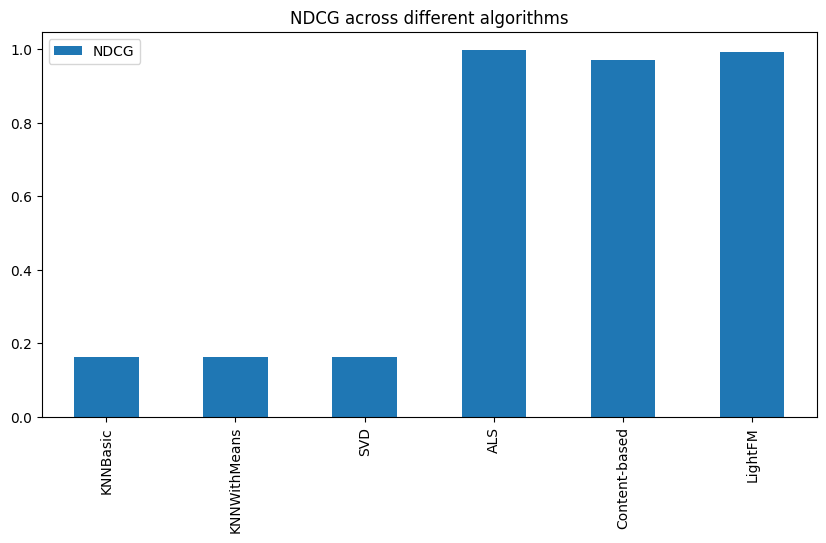

In [29]:
df_surprise_ndcg = df_metrics_surprise.loc[[
    ("KNNBasic", "ndcg"), ("KNNWithMeans", "ndcg"), ("SVD", "ndcg")
    ]]
df_surprise_ndcg.rename(index={
    ("KNNBasic", "ndcg"): "KNNBasic",
    ("KNNWithMeans", "ndcg"): "KNNWithMeans",
    ("SVD", "ndcg"): "SVD"
    }, inplace=True)

ndcg_dict = {
    "KNNBasic": df_surprise_ndcg.loc["KNNBasic"]['NDCG'],
    "KNNWithMeans": df_surprise_ndcg.loc["KNNWithMeans"]['NDCG'],
    "SVD": df_surprise_ndcg.loc["SVD"]['NDCG'],
    "ALS": ndcg_als,
    "Content-based": ave_ndcg,
    "LightFM": ndcg_score
}

ndcg_df = pd.DataFrame.from_dict(ndcg_dict, orient="index")
ndcg_df.rename(columns={0: "NDCG"}, inplace=True)
display(ndcg_df)

ndcg_df.plot(kind='bar', figsize=(10, 5))
plt.title("NDCG across different algorithms")
plt.show()

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Sample Recommendations Per Algorithm

shape of df_utility: (451, 33510)
shape of items_df: (33510, 2438)
shape of asins_df: (33510, 2)
User history of ¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A


,ProductName,category
reviewerID,,
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,acne_clarifying_face_toner_for_teens_by_natural_outcome_skin_care__salicylic_acid_facial_astringent_to_clear_acne_purify_pores__fragrance_free_alcohol_free_67_oz,Personal Care
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,"bosii_laptop_screen_extender_portable__14_inch_triple_ips_fhd_1080p_hdmi/usba/typec_extended_monitor_for_laptops_maximum_length:_1574""_compatible_with_windows_mac_travel_gaming_work",Electronic Devices
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,"legend_cookware_|_cast_iron_skillet_with_lid_|_large_12""_frying_pan_with_glass_lid_silicone_handle_for_oven_induction_cooking_pizza_sauteing_grilling",Kitchen
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,7_inch_touch_screen_gps_navigation_system_for_cars_and_trucks__2023_maps_spoken_directions_and_free_lifetime_updates,Car Stuff
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,gps_navigator_for_car_latest_2024_map_7_inch_touch_screen_car_gps_25616gb_voice_turn_direction_guidance_support_speed_and_red_light_warning_preinstalled_north_america_lifetime_map_free_update,Car Stuff
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,gps_navigation_for_cartruck_2024_maps_vehicle_gps_navigation_9_inch_touch_screen_voice_car_gps_for_lorry_speeding_warning_free_lifetime_maps_update_of_united_states_canada_mexico,Car Stuff
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,doll_stroller_toy_anivia_realistic_doll_stroller_heart_design_gifts_for_toddlers_and_girls_foldable_baby_doll_stroller_toy_pink_102,Children
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,deervalley_dv1f52102_ace_one_piece_toilet_dual_flush_11/16_gpf_elongated_toilet_for_bathroom_12''_roughin_standard_white_toilet_with_comfortable_seat_height_seat_included,Bedroom
¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A,usb_30_flash_drive_kootion_10_pack_32gb_usb_30_thumb_drive_retractable_32g_zip_drive_ultra_high_speed_usb_stick_jump_drive_rugged_memory_stick_with_led_indicator_for_data_storage_and_transfer,Peripheral Devices


Recommendations for ¤♤♡◇♧□○°_AGUTZC4GHLTGYHA3KBEDRF6MHB6A


,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,Global Baseline Average,LightFM
0,"Industrial Small Table Lamp,Modern Metal Bedside Lamp Nightstand Lamp for Bedroom Living Room Hallway Entryway, Iron Art Lampshade, LED Bulb Included, Gold","COMFEE CMO-C20M1WB Countertop Microwave Oven with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function, Speedy Cooking, Weight/Time Defrost, Memory function, Children Lock, 700W","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W","WATERH PureSip Adapt Water Bottle Stainless Steel Tumbler Straw Replacement for Vita, Simple Modern, Owala, Stanley, Hydro Flask(1 Filter + 5 Straws)",IMagicoo 32 Lovely Cute Writing Stationery Paper Letter Set with 16 Envelope + 1 Sheet Label Seal Sticker (Style-9(8.3x5.6)),Makeup: The Sunday Times Bestseller and practical step-by-step guide to makeup and beauty from much-loved makeup artist Hannah Martin,"Mighty Patch™ Original Patch from Hero Cosmetics - Hydrocolloid Acne Pimple Patch for Covering Zits and Blemishes, Spot Stickers for Face and Skin (72 Count)"
1,"Merax Suitcases With Wheels Lightweight Carry-On Luggage, TSA Lock and Reinforced Corners, 20 Inch Carry On Suitcases (White brown) …","COMMERCIAL CHEF 1.1 Cu Ft Microwave with 10 Power Levels, Small Microwave with Push Button, 1000W Countertop Microwave with Kitchen Timer, Door Lock, & Digital Controls, Stainless Steel",Yak About It Mini Fridge Dorm Station - Black,"Bear Air Fryer, 5.3Qt for Quick and Oil-Free Healthy Meals, Easy View, Smart Digital Touchscreen, Shake Reminder, Dishwasher-Safe&Non-stick Basket, Disposable Paper Liner and Recipes included,White","SSK 1TB USB SSD Solid State Flash Drive 550MB/s Super-Fast Transfer Speed USB 3.2 Gen2 Thumb(Jump) Drive Memory Stick + USB C Adapter for Type-c Smartphone, Laptop, MacBook/Pro/Air and More","Tide Hygienic Clean Heavy 10X Duty Laundry Detergent Liquid, Spring Meadow, 59 Loads, 92 Fl Oz, He Compatible",THE DESERT FALCONS an explosive action packed military aviation thriller adventure novel (Military Aviation Thrillers)
2,"ARESGAME AGV Series 500W Power Supply, 80 Plus Bronze Certified, Non Modular Power Supply, 5 Year Warranty","COMFEE CMO-C20M1WH Retro Microwave with 11 power levels, Fast Multi-stage Cooking, Turntable Reset Function Kitchen Timer, Speedy Cooking， Weight/Time Defrost, Memory function, Children Lock, 700W",Biore Clean Detox Toner 8 fl oz,"Merax Suitcases With Wheels Lightweight Carry-On Luggage, TSA Lock and Reinforced Corners, 20 Inch Carry On Suitcases (White brown) …","EZITSOL 64GB/128GB Write Protect USB Flash Drive with Physical Switch, Write Blocker Protection,128GB exFat USB3.0 High Speed up to 150MB/S,MLC Jump Drive Pendrive Thumb Drive Memory Stick","ESR Tempered Glass Screen Protector for iPhone 14 Pro (Armorite), Easy Installation Frame, Military-Grade Protection, Ultra Tough, Scratch Resistant, 2 Pack","Thermalright TL-S12 CPU Fan 120mm Case Cooler Fan Comes with ARGB Lighting Effect,PC PWM Silent Computer Fan with 1500RPM Speed, CPU Cooling Fan Black(Black,3-Pack)"
3,"TOSCiDO Tablet 2023 Android 12 Tablets 10.3 inch 2K FHD Tableta,15GB RAM 128GB Storage 2TB Expand,8 Core 12nm CPU Tablet PC,2000 * 1200 IPS, in-Cell LCD Screen,8000mAh,5G WiFi,GPS,8+13MP Camera,Black","GE JES1657BMTS Microwave Oven, Black Stainless Steel, 13.625 in","Garnier SkinActive Micellar Water for All Skin Types, Facial Cleanser & Makeup Remover, 13.5 Fl Oz (400mL), 1 Count (Packaging May Vary)","Wireless Retro Game Console, Retro Game Stick with Built-in 9 Emulators, 20,400+ Games, 4k Hdmi Output, and 2.4GHz Wireless Controller, Plug and Retro Play Video Games for Tv (64 G)","32GB MacOS Catalina 10.15.7 (Latest Version), Bootable USB Drive 3.0,Full Install/Upgrade/Downgrade Mac OS X",CHAOREN Ratchet Belts for Men 2-Pack - Stylish Leather Belts in Gift Set 35mm,"Tide Laundry Detergent Li

,KNNBasic,KNNWithMeans,SVD,ALS,Content-based,Global Baseline Average,LightFM
0,Bedroom,Kitchen,Kitchen,Travel Essentials,Office Supplies,Personal Care,Personal Care
1,Travel Essentials,Kitchen,Kitchen,Kitchen,Computer Components,Cleaning Material,Books
2,Computer Components,Kitchen,Personal Care,Travel Essentials,Peripheral Devices,Mobile Accessories,Computer Components
3,Electronic Devices,Kitchen,Personal Care,Electronic Devices,Peripheral Devices,Fashion,Cleaning Material
4,Kitchen,Kitchen,Personal Care,Kitchen,Peripheral Devices,Computer Components,Car Stuff
5,Kitchen,Personal Care,Bedroom,Bedroom,Peripheral Devices,Cleaning Material,Children
6,Kitchen,Personal Care,Bedroom,Children,Peripheral Devices,Cleaning Material,Personal Care
7,Mobile Accessories,Personal Care,Travel Essentials,Bathroom,Peripheral Devices,Computer Components,Peripheral Devices
8,Mobile Accessories,Personal Care,Travel Essentials,Peripheral Devices,Peripheral Devices,Books,Personal Care
9,Mobile Accessories,Personal Care,Travel Essentials,None,Peripheral Devices,Computer Components,Peripheral Devices


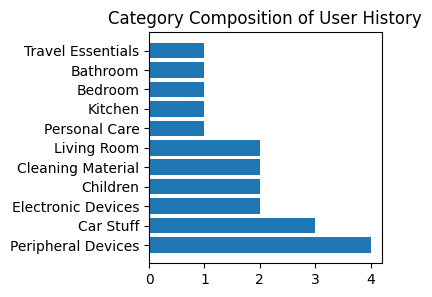

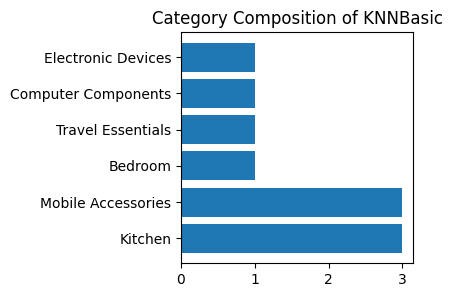

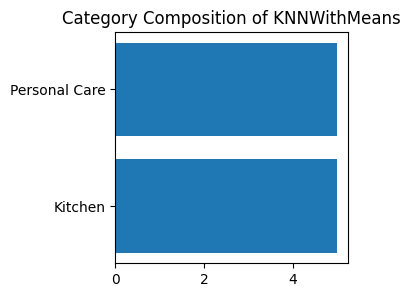

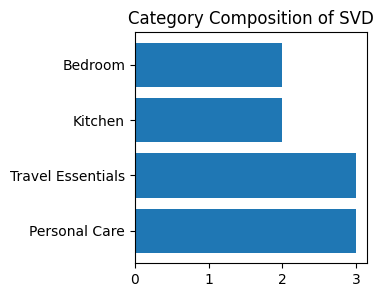

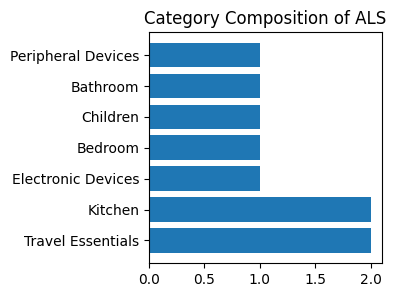

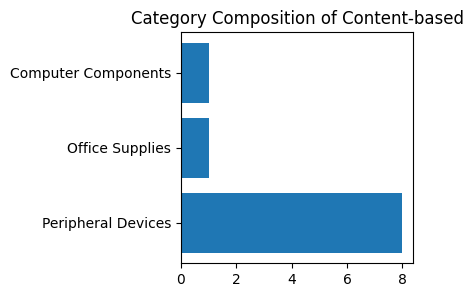

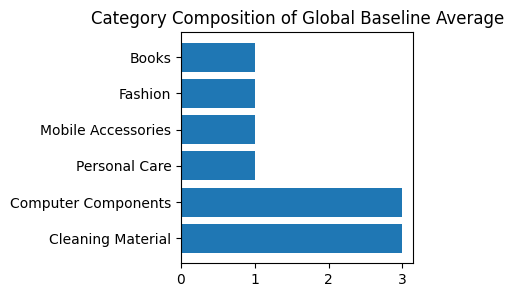

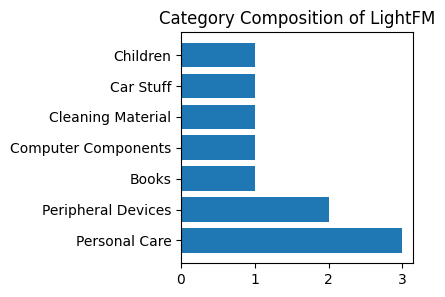

In [48]:
items_df, df_utility, reviews_df, asins_df = load_dataset()
try:
    reviews_df.set_index("reviewerID", inplace=True)
except:
    pass
df_list_of_recos = []
df_list_of_recos_categories = []
uid_recos = {}
asins_df = pd.merge(asins_df, reviews_df, on='ASIN', how='left')[
    ['ASIN', 'name', 'category']].drop_duplicates()
asins_df.set_index('ASIN', inplace=True)
pd.set_option('display.max_colwidth', 800)
for uid in top_uids:
    print(f"User history of {uid}")
    user_history = reviews_df.loc[uid][['ProductName', 'category']]
    display(user_history)
    uid_recos[uid] = {
        'KNNBasic': [],
        'KNNWithMeans': [],
        'SVD': [],
        'ALS': [],
        'Content-based': []
    }
    uid_recos[uid]["Global Baseline Average"] = recommendations_global_average_baseline[uid]
    uid_recos[uid]["KNNBasic"] = recommendations_surprise['KNNBasic'][uid]
    uid_recos[uid]["KNNWithMeans"] = recommendations_surprise['KNNWithMeans'][uid]
    uid_recos[uid]["SVD"] = recommendations_surprise['SVD'][uid]
    uid_recos[uid]["ALS"] = recommendations_als[uid]
    uid_recos[uid]["Content-based"] = recommendations_content['euc'][uid]
    uid_recos[uid]["LightFM"] = recommendations_lightfm[uid]
    

    df_dict = {}
    df_dict_categories = {}
    for algo in uid_recos[uid]:
        asins = [x for x in asins_df.loc[list(uid_recos[uid][algo])]['name'].tolist()][:10]
        df_dict[algo] = asins
        df_dict_categories[algo] = asins_df.loc[list(uid_recos[uid][algo])]['category'].tolist()

    df_recos_across_algos = pd.DataFrame.from_dict(df_dict, orient='index').T
    df_list_of_recos.append(df_recos_across_algos)

    df_recos_across_algos_categories = pd.DataFrame.from_dict(df_dict_categories, orient='index').T
    df_list_of_recos_categories.append(df_recos_across_algos_categories)

    print(f"Recommendations for {uid}")
    display(df_recos_across_algos)
    display(df_recos_across_algos_categories)

    val_counts_user_history = user_history["category"].value_counts()
    plt.figure(figsize=(3,3))
    plt.barh(width=val_counts_user_history,
            y=val_counts_user_history.index.tolist())
    plt.title("Category Composition of User History")
    plt.show()

    for algo in uid_recos[uid]:
        val_counts = df_recos_across_algos_categories[algo].value_counts()
        plt.figure(figsize=(3,3))
        plt.barh(width=val_counts,
                y=val_counts.index.tolist())
        plt.title(f"Category Composition of {algo}")
        plt.show()
    break # remove this to see all users

## Build Pickle File For Streamlit Application

## Build Pickle File For Streamlit Application

#### Export User History and Recommendations as Pickle file

In [31]:
# Save the dictionary to a pickle file
pd.to_pickle(uid_recos, 'user_hist_reco.pkl')

# Results and Recommendations

## Results

The recommendations served by the algorithms are more personalized compared to the baseline global average. There is a clear connection between the user's history and characteristics with the algorithm's recommendations, unlike the recommendations served by the baseline global average, which essentially is just the top K most popular items.

In terms of metrics, the offline evaluation metrics for the different algorithms demonstrated above are all by definition "good". However, the researchers would like to stress that the real determining factor for whether a recommender system performs well or not is based on eventual online evaluation metrics. That said, the researchers still expect the various recommender systems to perform well. For instance, the vision is that the recommendations are two-pronged:

* *Customers who bought this item also bought*: User-based collaborative filtering, ALS
* *Recommended for you*: Content-based filtering / Hybrid recommender using LightFM

In any case, future work on this project can simply mix and match or swap out algorithms.

The exact metrics for each algorithm is as follows:


* KNNBasic	0.266200
* KNNWithMeans	0.263800
* SVD	0.266397
* ALS	0.997882
* Content-based with Euclidean distance	0.965205
* Content-based with Cosine distance	0.984095
* Content-based with Jaccard distance	0.951475

Here we see that most algorithms except for KNNBasic, KNNWithMeans, and SVD perform well on a ranking basis.

## Recommendations

To make the recommender system more robust, the researchers suggest the following:

* Include items that are less popular than the ones included in the current itemset
* Include reviewers with less reviews than the ones included in the current userbase
* Fully understand and implement a hybrid recommender with tuned hyperparameters. In the case of this project, LightFM and ALS were used but hyperparameter tuning was not implemented. Hence, there is a possibility that these algorithms can actually improve after tuning.
* Use NLP techniques to extract keywords from the long-form features tag of products to identify more specific features.